In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [3]:
gen=pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', sep=';', decimal=',', parse_dates=True)
#generation_nandrop=generation_source.dropna()

temp=pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', sep=';', decimal=',', parse_dates=True)
#temperature_nandrop=temperature_source.drop(temperature_source.tail(95).index)

df_train=temp.merge(gen, on='DateTime', how='left')
df_train.drop(df_train.index[25560:], axis=0, inplace=True)

df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_train

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0.000000
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,0.000000
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,0.000008
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,0.000000
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,0.000008
...,...,...,...,...,...,...,...,...,...
25555,2021-11-30 19:00:00,7.1,5.2,76.8,3.1,220.0,25.0,6.0,0.000000
25556,2021-11-30 20:00:00,7.1,5.7,75.2,2.1,250.0,80.0,6.0,0.000000
25557,2021-11-30 21:00:00,5.8,3.1,83.4,4.1,280.0,80.0,7.0,0.000000
25558,2021-11-30 22:00:00,5.0,3.3,81.0,2.1,240.0,60.0,6.0,0.000000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25560 entries, 0 to 25559
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             25560 non-null  datetime64[ns]
 1   AirTemperature       25560 non-null  float64       
 2   ComfortTemperature   25560 non-null  float64       
 3   RelativeHumidity     25560 non-null  float64       
 4   WindSpeed            25560 non-null  float64       
 5   WindDirection        25560 non-null  float64       
 6   WWCode               19306 non-null  float64       
 7   EffectiveCloudCover  25560 non-null  float64       
 8   Generation           25560 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 2.0 MB


In [5]:
df_train.isna().sum()

DateTime                  0
AirTemperature            0
ComfortTemperature        0
RelativeHumidity          0
WindSpeed                 0
WindDirection             0
WWCode                 6254
EffectiveCloudCover       0
Generation                0
dtype: int64

In [6]:
df_train["WWCode"].fillna(method='ffill',inplace=True)
df_train.isna().sum()

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
Generation             0
dtype: int64

In [7]:


# get test data from the desired date index (25560 index is where the date-time is 01-12-2021)
df_test = temp.iloc[25560:26304] 
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 25560 to 26303
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             744 non-null    datetime64[ns]
 1   AirTemperature       744 non-null    float64       
 2   ComfortTemperature   744 non-null    float64       
 3   RelativeHumidity     744 non-null    float64       
 4   WindSpeed            744 non-null    float64       
 5   WindDirection        744 non-null    float64       
 6   WWCode               744 non-null    float64       
 7   EffectiveCloudCover  744 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 46.6 KB


In [9]:
df_test.isna().sum()

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
dtype: int64

In [10]:
for (columnName, columnData) in df_train.iteritems():
    print(df_test.isin({columnName: [*columnData]}).sum())

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
dtype: int64
DateTime                 0
AirTemperature         744
ComfortTemperature       0
RelativeHumidity         0
WindSpeed                0
WindDirection            0
WWCode                   0
EffectiveCloudCover      0
dtype: int64
DateTime                 0
AirTemperature           0
ComfortTemperature     744
RelativeHumidity         0
WindSpeed                0
WindDirection            0
WWCode                   0
EffectiveCloudCover      0
dtype: int64
DateTime                 0
AirTemperature           0
ComfortTemperature       0
RelativeHumidity       744
WindSpeed                0
WindDirection            0
WWCode                   0
EffectiveCloudCover      0
dtype: int64
DateTime                 0
AirTemperature           0
ComfortTemperature       0
RelativeHumidity   

In [11]:
df_test['WWCode'] = df_test['WWCode'].replace([84], 83)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
len(df_train), len(df_test)

(25560, 744)

In [13]:
#df_train['Generation'] = np.log1p(df_train["Generation"].values)


#Thanks to other partipiciant's work I know exactly how to deal with this feature (reference link at the end of the notebook)
#merged['WWCode']=merged['WWCode'].replace([84], 83)

#saving copies
#datetime_copy=merged['DateTime']
#merged_with_dt_as_column=merged
#merged=merged.set_index('DateTime')
#merged.index.freq='H'

# normalizing
#merged['WindDirection']=merged['WindDirection']/10
#merged['WWCode']=merged['WWCode']/10

#merged

In [14]:
df_train=df_train.set_index('DateTime')
df_train.index.freq='H'

In [15]:
#training data
#df_for_training=merged.drop(merged.tail(31*24).index)
df_for_training=df_train


# hyperparameters
LEARNING_RATE=1e-3
DECAY=1e-5
MAX_EPOCHS=5
BATCH_SIZE=100
VALID_SPLIT=0.2
PATIENCE=10

n_future=1*24
n_past=1*24

scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

#creating the required shape for LSTM network (samples (rows), timesteps, features (columns))
trainX=[]
trainY=[]

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY=np.array(trainX), np.array(trainY)

#model architecture
model=Sequential()

model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1))

#optimizing and training
opt=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
early_stopping=tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)

history=model.fit(trainX, trainY,
        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                 callbacks=[early_stopping], verbose=1)


#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#y2 = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#model.fit(partial_x_train, partial_y_train, epochs=Numepochs, batch_size=Batchsize, validation_data=(x_val, y_val))

2022-02-20 13:34:31.857024: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-20 13:34:33.739009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
205/205 [==============================] - 54s 201ms/step - loss: 0.5473 - mse: 0.5473 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 2/5
205/205 [==============================] - 38s 184ms/step - loss: 0.1224 - mse: 0.1224 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 3/5
205/205 [==============================] - 37s 181ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 4/5
205/205 [==============================] - 37s 180ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/5
205/205 [==============================] - 37s 180ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0065 - val_mse: 0.0065


Minimum Validation Loss: 0.0065


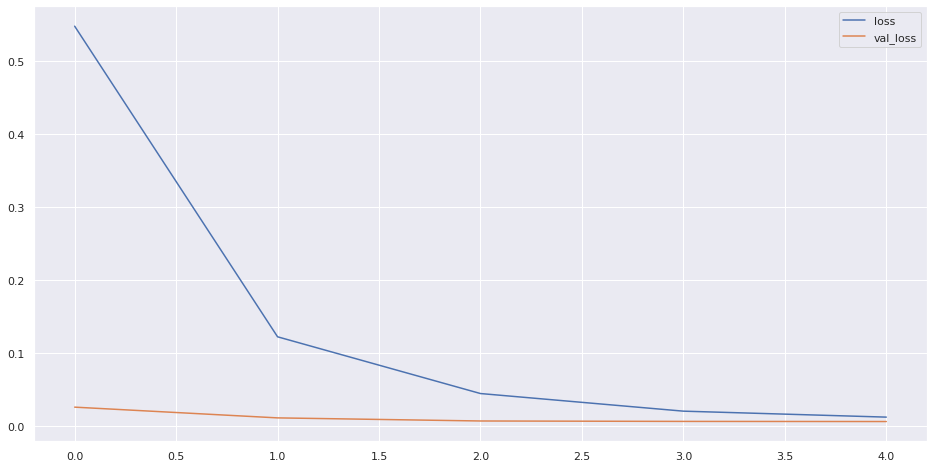

In [16]:


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(16,8))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

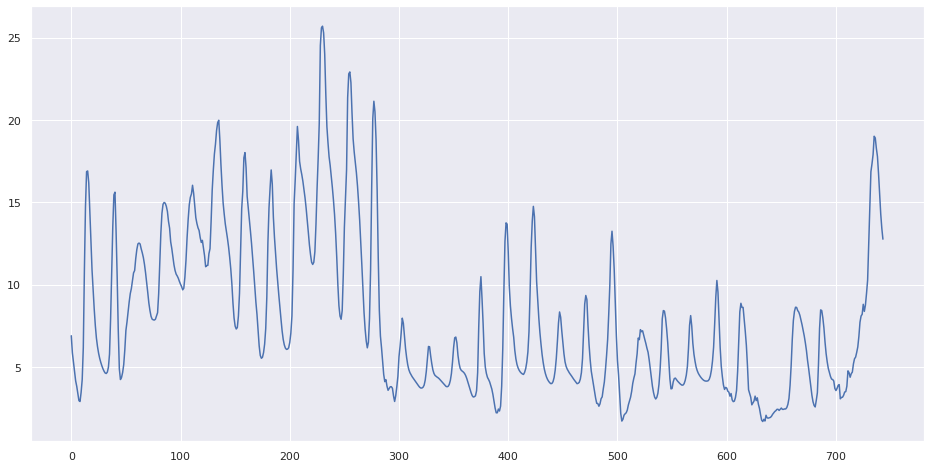

In [17]:
n_hours_for_prediction=24*31 

forecast=model.predict(trainX[-n_hours_for_prediction:])

forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]


plt.figure(figsize=(16,8))
plt.plot(y_pred_future)

In [18]:
from sklearn.metrics import mean_squared_error
rmse_score = np.sqrt(mean_squared_error(trainY[-n_hours_for_prediction:], y_pred_future))

score_list = []
score_list.append(rmse_score)


print(score_list)
print("RMSE Score: ", np.mean(score_list))

[8.940051942814199]
RMSE Score:  8.940051942814199


In [19]:
submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission['Generation'] = y_pred_future
submission.to_csv('submission.csv', index=False)
print("Submission File Created")

Submission File Created
